<a href="https://colab.research.google.com/github/mtodisco10/fastaiProjects/blob/master/first_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate

In [5]:
path = Path('architecture/buildings')
def download_pics(category_lst):
  for f in category_lst:
    print(f'Downloading {f} images')
    folder = f
    file = f + '.csv'
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(file, dest, max_pics=200)

category_lst = ['classical','gothic','modern','victorian']
download_pics(category_lst)

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

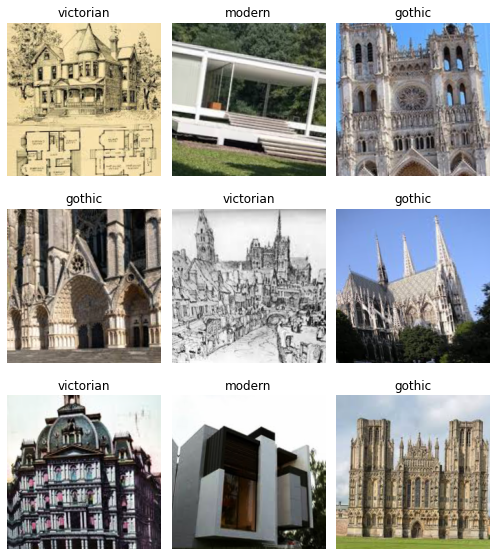

In [7]:
data.show_batch(rows=3, figsize=(7,8))

In [8]:
classes = ['classical', 'gothic', 'modern', 'victorian']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

classical


gothic


modern


victorian


# Train the Model

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.037251,1.110331,0.433735,00:05
1,1.373585,0.893186,0.228916,00:05
2,1.021533,0.814836,0.216867,00:05
3,0.859981,0.742925,0.180723,00:05


In [12]:
learn.save('stage-1')

In [13]:
learn.unfreeze()

In [14]:
learn.fit_one_cycle(6, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.294751,0.721369,0.192771,00:05
1,0.322177,0.849119,0.216867,00:05
2,0.293594,0.690099,0.180723,00:05
3,0.254024,0.552522,0.120482,00:05
4,0.228639,0.547877,0.108434,00:05
5,0.202716,0.561202,0.108434,00:05


In [15]:
interp = ClassificationInterpretation.from_learner(learn)

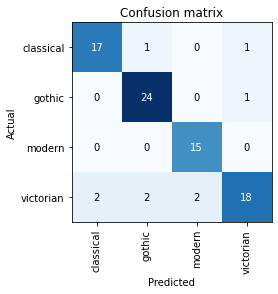

In [16]:
interp.plot_confusion_matrix()

In [17]:
print('This isn\'t too shabby for a first try')
learn.save('stage-2')

This isn't too shabby for a first try


Cleaning the Data

In [18]:
from fastai.widgets import *
db = (ImageList.from_folder(path)
.split_none()
.label_from_folder()
.transform(get_transforms(), size=224)
.databunch())
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

In [19]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Deploying the Model

In [20]:
learn.export()

In [21]:
defaults.device = torch.device('cpu')

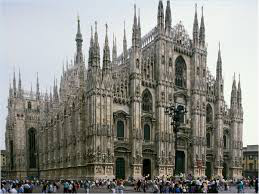

In [22]:
img = open_image(path/'gothic'/'00000000.jpg')
img

In [23]:
learn = load_learner(path)

In [24]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class.obj

'gothic'

## Starlette

In [25]:
from starlette.applications import Starlette
from starlette.responses import JSONResponse
import uvicorn

In [26]:
app = Starlette(debug=True)
@app.route('/')
async def homepage(request):
    return JSONResponse({'MySAMPLE': 'It works!'})
if __name__ == '__main__':
    uvicorn.run(app, host='0.0.0.0', port=8000)

RuntimeError: ignored

INFO:     Started server process [843]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


In [1]:
from fastai.vision import
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
   bytes = await get_bytes(request.query_params["url"])
   img = open_image(BytesIO(bytes))
   _,_,losses = learner.predict(img)
   return JSONResponse({
"predictions": sorted(zip(cat_learner.data.classes, map(float, losses)),key=lambda p: p[1],reverse=True)
})

SyntaxError: ignored